In [1]:
using Images
using PyPlot
using Printf
using Random
using Statistics
using LinearAlgebra
using Interpolations

include("Common.jl")


#---------------------------------------------------------
# Loads keypoints from JLD2 container.
#
# INPUTS:
#   filename     JLD2 container filename
#
# OUTPUTS:
#   keypoints1   [n x 2] keypoint locations (of left image)
#   keypoints2   [n x 2] keypoint locations (of right image)
#
#---------------------------------------------------------
function loadkeypoints(filename::String)
  data = load(filename)
  keypoints1 = data["keypoints1"]
  keypoints2 = data["keypoints2"]
  @assert size(keypoints1,2) == 2
  @assert size(keypoints2,2) == 2
  return keypoints1::Array{Int64,2}, keypoints2::Array{Int64,2}
end


#---------------------------------------------------------
# Compute pairwise Euclidean square distance for all pairs.
#
# INPUTS:
#   features1     [128 x m] descriptors of first image
#   features2     [128 x n] descriptors of second image
#
# OUTPUTS:
#   D             [m x n] distance matrix
#
#---------------------------------------------------------
function euclideansquaredist(features1::Array{Float64,2},features2::Array{Float64,2})
  D = (sum(features1.^2,dims=1)' .+ sum(features2.^2,dims=1)) - 2*(features1'*features2)
  @assert size(D) == (size(features1,2),size(features2,2))
  return D::Array{Float64,2}
end


#---------------------------------------------------------
# Find pairs of corresponding interest points given the
# distance matrix.
#
# INPUTS:
#   p1      [m x 2] keypoint coordinates in first image.
#   p2      [n x 2] keypoint coordinates in second image.
#   D       [m x n] distance matrix
#
# OUTPUTS:
#   pairs   [min(N,M) x 4] vector s.t. each row holds
#           the coordinates of an interest point in p1 and p2.
#
#---------------------------------------------------------
function findmatches(p1::Array{Int,2},p2::Array{Int,2},D::Array{Float64,2})
  if size(p1,1) <= size(p2,1)
    _,lidx = findmin(D,dims=2)
    idx = zeros(Integer, size(lidx,1))
    for i = 1:length(lidx)
      tmp = CartesianIndex(lidx[i][2])
      idx[i] = tmp
    end
    pairs = [p1 p2[idx,:]]
  else
    _,lidx = findmin(D,1)
    idx = zeros(Integer, size(lidx,1))
    for i = 1:length(lidx)
      tmp = CartesianIndex(lidx[i][1])
      idx[i] = tmp
    end
    pairs = [p1[idx,:] p2]
  end
  @assert size(pairs) == (min(size(p1,1),size(p2,1)),4)
  return pairs::Array{Int,2}
end


#---------------------------------------------------------
# Show given matches on top of the images in a single figure.
# Concatenate the images into a single array.
#
# INPUTS:
#   im1     first grayscale image
#   im2     second grayscale image
#   pairs   [n x 4] vector of coordinates containing the
#           matching pairs.
#
#---------------------------------------------------------
function showmatches(im1::Array{Float64,2},im2::Array{Float64,2},pairs::Array{Int,2})
  figure()
  imshow([im1 im2],"gray",interpolation="none")
  axis("off")
  c = size(im1,2)
  n = size(pairs,1)
  for i = 1:n
    plot([pairs[i,1],pairs[i,3]+c], [pairs[i,2],pairs[i,4]])
  end
  return nothing::Nothing
end


#---------------------------------------------------------
# Computes the required number of iterations for RANSAC.
#
# INPUTS:
#   p    probability that any given correspondence is valid
#   k    number of samples drawn per iteration
#   z    total probability of success after all iterations
#
# OUTPUTS:
#   n   minimum number of required iterations
#
#---------------------------------------------------------
function computeransaciterations(p::Float64,k::Int,z::Float64)
  n = Int(ceil(log(1-z) / log(1-p^k)))
  return n::Int
end


#---------------------------------------------------------
# Randomly select k corresponding point pairs.
#
# INPUTS:
#   points1    given points in first image
#   points2    given points in second image
#   k          number of pairs to select
#
# OUTPUTS:
#   sample1    selected [kx2] pair in left image
#   sample2    selected [kx2] pair in right image
#
#---------------------------------------------------------
function picksamples(points1::Array{Int,2},points2::Array{Int,2},k::Int)
  idx = randperm(size(points1,1))[1:k]
  sample1 = points1[idx,:]
  sample2 = points2[idx,:]
  @assert size(sample1) == (k,2)
  @assert size(sample2) == (k,2)
  return sample1::Array{Int,2},sample2::Array{Int,2}
end


#---------------------------------------------------------
# Conditioning: Normalization of coordinates for numeric stability.
#
# INPUTS:
#   points    unnormalized coordinates
#
# OUTPUTS:
#   U         normalized (conditioned) coordinates
#   T         [3x3] transformation matrix that is used for
#                   conditioning
#
#---------------------------------------------------------
function condition(points::Array{Float64,2})
  P = points[1:2,:] ./ points[3:3,:]
  t = mean(P,dims=2)
  s = 0.5 * maximum(abs.(P))
  T = [[Matrix{Float64}(I, 2, 2) -t]./s; 0 0 1];

  U = T*points
  @assert size(U) == size(points)
  @assert size(T) == (3,3)
  return U::Array{Float64,2},T::Array{Float64,2}
end


#---------------------------------------------------------
# Estimates the homography from the given correspondences.
#
# INPUTS:
#   points1    correspondences in left image
#   points2    correspondences in right image
#
# OUTPUTS:
#   H         [3x3] estimated homography
#
#---------------------------------------------------------
function computehomography(points1::Array{Int,2}, points2::Array{Int,2})
  points1 = Common.cart2hom(points1')
  points2 = Common.cart2hom(points2')

  x1 = points1[1:1,:]'
  y1 = points1[2:2,:]'
  x2 = points2[1:1,:]'
  y2 = points2[2:2,:]'
  O = zeros(size(x1,1))
  I = ones(size(x1,1))
  A2 = [ O   O   O  x1 y1 I -x1.*y2 -y1.*y2 -y2;
       -x1 -y1 -I  O  O  O  x1.*x2  y1.*x2  x2]

  U1,T1 = condition(points1)
  U2,T2 = condition(points2)
  x1 = U1[1:1,:]'
  y1 = U1[2:2,:]'
  x2 = U2[1:1,:]'
  y2 = U2[2:2,:]'
  O = zeros(size(x1,1))
  I = ones(size(x1,1))
  A = [ O   O   O  x1 y1 I -x1.*y2 -y1.*y2 -y2;
       -x1 -y1 -I  O  O  O  x1.*x2  y1.*x2  x2]

  # @printf("Condition number before: %.2f \t after %.2f\n", cond(A2), cond(A))

  _,_,V = svd(A,full=true)
  Hb = reshape(V[:,end],(3,3))'
  H = T2\Hb*T1
  @assert size(H) == (3,3)
  return H::Array{Float64,2}
end


#---------------------------------------------------------
# Computes distances for keypoints after transformation
# with the given homography.
#
# INPUTS:
#   H          [3x3] homography
#   points1    correspondences in left image
#   points2    correspondences in right image
#
# OUTPUTS:
#   d2         distance measure using the given homography
#
#---------------------------------------------------------
function computehomographydistance(H::Array{Float64,2},points1::Array{Int,2},points2::Array{Int,2})
  x1 = Common.cart2hom(points1')
  x2 = Common.cart2hom(points2')
  x1t = H \ x2
  x2t = H* x1
  x1t = Common.cart2hom(Common.hom2cart(x1t))
  x2t = Common.cart2hom(Common.hom2cart(x2t))
  d2 = sum((x1-x1t).^2 + (x2-x2t).^2, dims=1)
  @assert length(d2) == size(points1,1)
  return d2::Array{Float64,2}
end


#---------------------------------------------------------
# Compute the inliers for a given distances and threshold.
#
# INPUTS:
#   distance   homography distances
#   thresh     threshold to decide whether a distance is an inlier
#
# OUTPUTS:
#  n          number of inliers
#  indices    indices (in distance) of inliers
#
#---------------------------------------------------------
function findinliers(distance::Array{Float64,2},thresh::Float64)
  indices = findall(distance[1,:].<thresh)
  n = length(indices)
  return n::Int,indices::Array{Int,1}
end


#---------------------------------------------------------
# RANSAC algorithm.
#
# INPUTS:
#   pairs     potential matches between interest points.
#   thresh    threshold to decide whether a homography distance is an inlier
#   n         maximum number of RANSAC iterations
#
# OUTPUTS:
#   bestinliers   [n x 1 ] indices of best inliers observed during RANSAC
#
#   bestpairs     [4x4] set of best pairs observed during RANSAC
#                 i.e. 4 x [x1 y1 x2 y2]
#
#   bestH         [3x3] best homography observed during RANSAC
#
#---------------------------------------------------------
function ransac(pairs::Array{Int,2},thresh::Float64,n::Int)
  points1 = pairs[:,1:2]
  points2 = pairs[:,3:4]
  bestinliers = []
  bestpairs = []
  bestH = []
  for i = 1:n
    sample1,sample2 = picksamples(points1,points2,4)
    H = computehomography(sample1,sample2)
    if abs(det(H)) < 1e-6
      continue
    end
    d2 = computehomographydistance(H,points1,points2)
    ninliers,indices = findinliers(d2,thresh)
    if ninliers > length(bestinliers)
      bestinliers = indices
      bestpairs = [sample1 sample2]
      bestH = H
    end
  end
  @assert size(bestinliers,2) == 1
  @assert size(bestpairs) == (4,4)
  @assert size(bestH) == (3,3)
  return bestinliers::Array{Int,1},bestpairs::Array{Int,2},bestH::Array{Float64,2}
end


#---------------------------------------------------------
# Recompute the homography based on all inliers
#
# INPUTS:
#   pairs     pairs of keypoints
#   inliers   inlier indices.
#
# OUTPUTS:
#   H         refitted homography using the inliers
#
#---------------------------------------------------------
function refithomography(pairs::Array{Int64,2}, inliers::Array{Int64,1})
  inliers1 = pairs[inliers,1:2]
  inliers2 = pairs[inliers,3:4]
  H = computehomography(inliers1,inliers2)
  @assert size(H) == (3,3)
  return H::Array{Float64,2}
end


#---------------------------------------------------------
# Show panorama stitch of both images using the given homography.
#
# INPUTS:
#   im1     first grayscale image
#   im2     second grayscale image
#   H       [3x3] estimated homography between im1 and im2
#
#---------------------------------------------------------
function showstitch(im1::Array{Float64,2},im2::Array{Float64,2},H::Array{Float64,2})
  height,width = size(im1)
  warped = [im1[:,1:300] zeros(height,400)]
  for x = 301:700
    for y = 1:size(im1,1)
      ix,iy = Common.hom2cart(H*[x; y; 1])
      warped[y,x] = Images.bilinear_interpolation(im2, iy, ix)
    end
  end
 
  figure()
  imshow(warped,"gray",interpolation="none")
  axis("off")
  title("Stitched Images")
  return nothing::Nothing
end


#---------------------------------------------------------
# Problem 2: Image Stitching
#---------------------------------------------------------
function problem2()
  # SIFT Parameters
  sigma = 1.4             # standard deviation for presmoothing derivatives

  # RANSAC Parameters
  ransac_threshold = 50.0 # inlier threshold
  p = 0.5                 # probability that any given correspondence is valid
  k = 4                   # number of samples drawn per iteration
  z = 0.99                # total probability of success after all iterations

  # load images
  im1 = PyPlot.imread("a3p2a.png")
  im2 = PyPlot.imread("a3p2b.png")

  # Convert to double precision
  im1 = Float64.(im1)
  im2 = Float64.(im2)

  # load keypoints
  keypoints1, keypoints2 = loadkeypoints("keypoints.jld2")

  # extract SIFT features for the keypoints
  features1 = Common.sift(keypoints1,im1,sigma)
  features2 = Common.sift(keypoints2,im2,sigma)

  # compute chi-square distance  matrix
  D = euclideansquaredist(features1,features2)

  # find matching pairs
  pairs = findmatches(keypoints1,keypoints2,D)

  # show matches
  showmatches(im1,im2,pairs)
  title("Putative Matching Pairs")

  # compute number of iterations for the RANSAC algorithm
  niterations = computeransaciterations(p,k,z)

  # apply RANSAC
  bestinliers,bestpairs,bestH = ransac(pairs,ransac_threshold,niterations)
  @printf(" # of bestinliers : %d", length(bestinliers))

  # show best matches
  showmatches(im1,im2,bestpairs)
  title("Best 4 Matches")

  # show all inliers
  showmatches(im1,im2,pairs[bestinliers,:])
  title("All Inliers")

  # stitch images and show the result
  showstitch(im1,im2,bestH)

  # recompute homography with all inliers
  H = refithomography(pairs,bestinliers)
  #H = load("H.jld2", "H")
  showstitch(im1,im2,H)

  return nothing::Nothing
end


problem2 (generic function with 1 method)

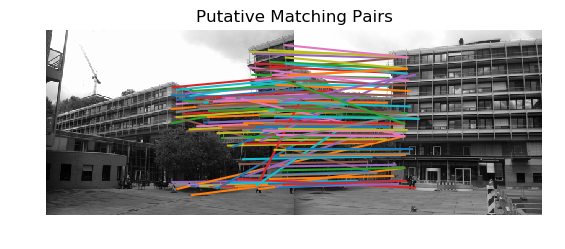

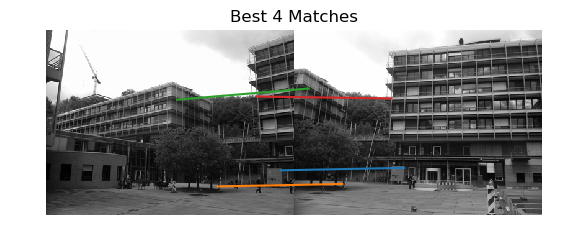

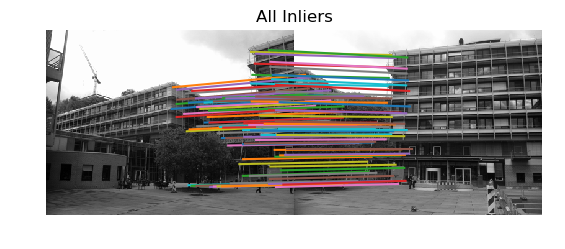

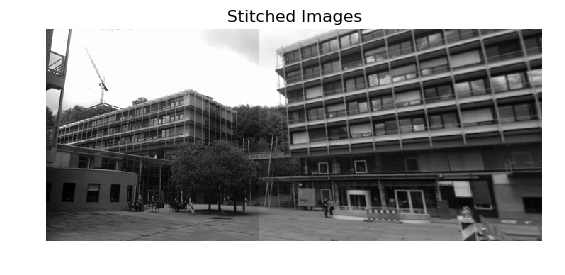

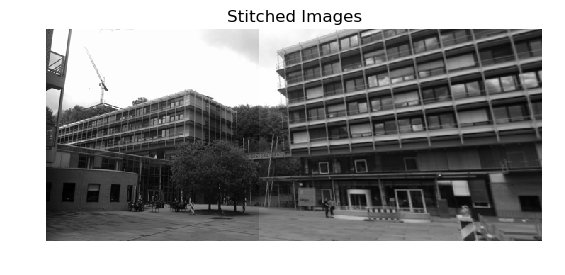

 # of bestinliers : 86

In [2]:
problem2()